In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
import random
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL one class",
    name= "centralized training_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.0,
    "learning_rate_TL": 0.0001,
    "batch_size_TL": 64,
    "decay_TL":1e-5,
    'num_rounds_TL': 40, 
    'epochs_TL': 100,
    'dropout_TL': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

transfer_i = random.randint(0, 3)
configuration  = dict(wandb.config)


def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.5):
    trainloader = []
    valloader = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        print(data.size())
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        print(data_resampled.shape)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        train_size = int(train_ratio * len(dataset))
        test_size = len(dataset) - train_size
        val_size = int(val_ratio * test_size)
        test_size = test_size - val_size

        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        if i == transfer_i:
            trainloader_transfer = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            valloader_transfer = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        else:
            trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
            valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))
            
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    
    # Create a DataLoader for the combined test data
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader, trainloader_transfer, valloader_transfer

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs, name):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        wandb.log({f'{name} training accuraccy': train_acc,
                  f'{name} validation accuracy': test_acc})
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 50.0 Testing accuracy: 46.715328216552734.

Epoch 2/100
Epoch 2: Training accuracy: 50.09123992919922 Testing accuracy: 53.284671783447266.

Epoch 3/100
Epoch 3: Training accuracy: 60.94890594482422 Testing accuracy: 57.66423416137695.

Epoch 4/100
Epoch 4: Training accuracy: 62.04379653930664 Testing accuracy: 55.47445297241211.

Epoch 5/100
Epoch 5: Training accuracy: 65.96715545654297 Testing accuracy: 62.77372360229492.

Epoch 6/100
Epoch 6: Training accuracy: 62.95620346069336 Testing accuracy: 59.124088287353516.

Epoch 7/100
Epoch 7: Training accuracy: 68.43065643310547 Testing accuracy: 64.23357391357422.

Epoch 8/100
Epoch 8: Training accuracy: 69.06934356689453 Testing accuracy: 66.42335510253906.

Epoch 9/100
Epoch 9: Training accuracy: 69.34306335449219 Testing accuracy: 64.9635009765625.

Epoch 10/100
Epoch 10: Training accuracy: 72.08029174804688 Testing accuracy: 71.53284454345703.

Epoch 11/100
Epoch 11: Training accuracy: 71.441

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


centralized training accuraccy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
centralized validation accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████
centralized training accuraccy,92.42701
centralized validation accuracy,86.13139


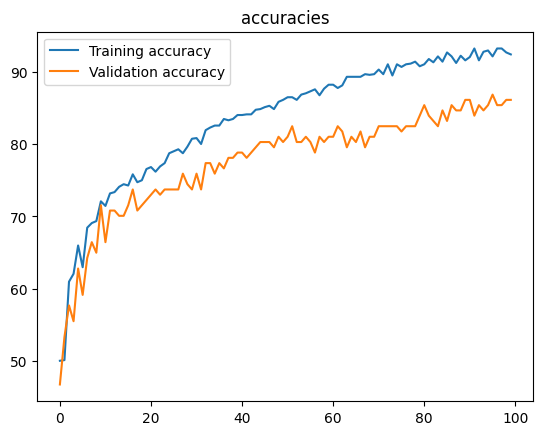

In [6]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'], name='centralized')
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

## transfer learning

In [7]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL one class",
    name= "Transfer Learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.0,
    "learning_rate_TL": 0.0001,
    "batch_size_TL": 64,
    "decay_TL":1e-5,
    'num_rounds_TL': 40, 
    'epochs_TL': 100,
    'dropout_TL': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

In [8]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader, azure_train_loaders_transfer, azure_val_loaders_transfer = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

torch.Size([1002, 4, 50])
(1670, 4, 50)
torch.Size([936, 4, 50])
(1560, 4, 50)
torch.Size([1242, 4, 50])
(2070, 4, 50)
torch.Size([1014, 4, 50])
(1690, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 51.04166793823242 Testing accuracy: 43.589744567871094.

Epoch 2/100
Epoch 2: Training accuracy: 62.58012771606445 Testing accuracy: 53.20512771606445.

Epoch 3/100
Epoch 3: Training accuracy: 65.14423370361328 Testing accuracy: 56.410255432128906.

Epoch 4/100
Epoch 4: Training accuracy: 68.99038696289062 Testing accuracy: 62.17948532104492.

Epoch 5/100
Epoch 5: Training accuracy: 70.75320434570312 Testing accuracy: 64.1025619506836.

Epoch 6/100
Epoch 6: Training accuracy: 71.07371520996094 Testing accuracy: 66.66666412353516.

Epoch 7/100
Epoch 7: Training accuracy: 73.4775619506836 Testing accuracy: 67.94871520996094.

Epoch 8/100
Epoch 8: Training accuracy: 74.19871520996094 Testing accuracy: 69.87179565429688.

Epoch 9/100
Epoch 9: Training accuracy: 75.72115325927734 Testing accuracy: 68.5897445678711.

Epoch 10/100
Epoch 10: Training accuracy: 75.88140869140625 Testing accuracy: 68.5897445678711.

Epoch 11/100
Epoch 11: Training accurac

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


transfer training accuraccy,▁▄▅▆▆▆▆▆▇▇▇▇▇▇█████▇█████████████████▇██
transfer validation accuracy,▁▃▅▆▆▆▆▆▆▆▇▇▇▇▇█▇▇▇▇██▇█▇██▇█▇███████▇██
transfer training accuraccy,84.77564
transfer validation accuracy,79.48718


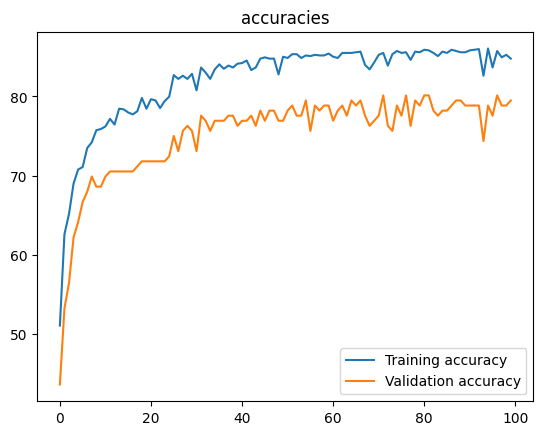

In [9]:
losses_transfer = []
accuracies_transfer = []
for epoch in range(1):
    train(net, azure_train_loaders_transfer, azure_val_loaders_transfer, configuration, configuration['epochs'], name= "transfer")
    loss, accuracy = test(net, azure_val_loaders_transfer, configuration)
    losses_transfer.append(loss)
    accuracies_transfer.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
losses_transfer, accuracy_transfer = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
<!-- # plt.plot(accuracies) -->
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## Federated Learning

In [10]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL one class",
    name= "federated learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.0,
    "learning_rate_TL": 0.0001,
    "batch_size_TL": 64,
    "decay_TL":1e-5,
    'num_rounds_TL': 40, 
    'epochs_TL': 100,
    'dropout_TL': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

In [11]:
# Define the CNN architecture
class Neural_Network_FL(nn.Module):
    def __init__(self):
        super(Neural_Network_FL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [12]:
def train_FL(model, train_loaders,test_loader, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()


In [13]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FL, parameters_centralized)
step = 0

In [14]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_FL(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FL, trainloader, valloader, configuration).to_client()


In [15]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config):
    testloader = azure_test_loader
    set_parameters(net_FL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-08-12 14:16:25,258	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 32.0, 'node:__internal_head__': 1.0, 'node:192.168.1.146': 1.0, 'memory': 122093650125.0, 'object_store_memory': 56611564339.0, 'GPU': 2.0, 'accelerator_type:G': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.0702885010025718 / accuracy 49.928470611572266
(ClientAppActor pid=2290805) 
(ClientAppActor pid=2290805) Epoch 1/100
(ClientAppActor pid=2290805) Epoch 1: Training accuracy: 50.299400329589844 Testing accuracy: 45.50898361206055.
(ClientAppActor pid=2290805) Epoch 2: Training accuracy: 50.299400329589844 Testing accuracy: 45.50898361206055.
(ClientAppActor pid=2290805) Epoch 3: Training accuracy: 50.299400329589844 Testing accuracy: 45.50898361206055.
(ClientAppActor pid=2290805) Epoch 4: Training accuracy: 50.299400329589844 Testing accuracy: 45.50898361206055.
(ClientAppActor pid=2290805)  [repeated 280x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=2290805) Epoch 81/100 [repeated 280x across cluster]
(ClientAppActor pid=2290805) Epoch 87: Training accuracy: 50.7246360778

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.06296704574064775, {'accuracy': tensor(49.9285, device='cuda:0')}, 7.068868450005539)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.06296704574064775 / accuracy 49.928470611572266
(ClientAppActor pid=2290805)  [repeated 282x across cluster]
(ClientAppActor pid=2290805) Epoch 63/100 [repeated 282x across cluster]
(ClientAppActor pid=2290805) Epoch 69: Training accuracy: 50.72463607788086 Testing accuracy: 48.79227066040039. [repeated 282x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.06283263726667924, {'accuracy': tensor(49.9285, device='cuda:0')}, 12.673706745961681)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.06283263726667924 / accuracy 49.928470611572266
(ClientAppActor pid=2290804)  [repeated 294x across cluster]
(ClientAppActor pid=2290804) Epoch 57/100 [repeated 294x across cluster]
(ClientAppActor pid=2290804) Epoch 65: Training accuracy: 61.97604751586914 Testing accuracy: 58.68263626098633. [repeated 296x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.061996649612079964, {'accuracy': tensor(73.1044, device='cuda:0')}, 17.685091070015915)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.061996649612079964 / accuracy 73.10443115234375
(ClientAppActor pid=2290804)  [repeated 296x across cluster]
(ClientAppActor pid=2290804) Epoch 53/100 [repeated 296x across cluster]
(ClientAppActor pid=2290804) Epoch 59: Training accuracy: 66.78743743896484 Testing accuracy: 68.1159439086914. [repeated 294x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.058676925572482025, {'accuracy': tensor(71.6738, device='cuda:0')}, 23.13118555105757)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.058676925572482025 / accuracy 71.67382049560547
(ClientAppActor pid=2290805)  [repeated 282x across cluster]
(ClientAppActor pid=2290805) Epoch 35/100 [repeated 282x across cluster]
(ClientAppActor pid=2290805) Epoch 41: Training accuracy: 75.9661865234375 Testing accuracy: 78.26087188720703. [repeated 282x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 0.05420827865600586, {'accuracy': tensor(77.2532, device='cuda:0')}, 28.770188388065435)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05420827865600586 / accuracy 77.25321960449219
(ClientAppActor pid=2290805)  [repeated 285x across cluster]
(ClientAppActor pid=2290805) Epoch 21/100 [repeated 285x across cluster]
(ClientAppActor pid=2290805) Epoch 28: Training accuracy: 75.07396697998047 Testing accuracy: 75.7396469116211. [repeated 287x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (6, 0.05098881504752419, {'accuracy': tensor(76.1087, device='cuda:0')}, 33.89781239605509)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05098881504752419 / accuracy 76.10872650146484
(ClientAppActor pid=2290805)  [repeated 295x across cluster]
(ClientAppActor pid=2290805) Epoch 98/100 [repeated 295x across cluster]
(ClientAppActor pid=2290804) Epoch 29: Training accuracy: 70.95808410644531 Testing accuracy: 66.4670639038086. [repeated 301x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (7, 0.04924242063002153, {'accuracy': tensor(78.1116, device='cuda:0')}, 38.8647531879833)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04924242063002153 / accuracy 78.11158752441406
(ClientAppActor pid=2290805)  [repeated 307x across cluster]
(ClientAppActor pid=2290805) Epoch 100/100 [repeated 307x across cluster]
(ClientAppActor pid=2290804) Epoch 33: Training accuracy: 76.10946655273438 Testing accuracy: 75.7396469116211. [repeated 304x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (8, 0.0484279990196228, {'accuracy': tensor(78.5408, device='cuda:0')}, 43.89919655804988)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0484279990196228 / accuracy 78.540771484375
(ClientAppActor pid=2290805)  [repeated 302x across cluster]
(ClientAppActor pid=2290805) Epoch 23/100 [repeated 301x across cluster]
(ClientAppActor pid=2290805) Epoch 30: Training accuracy: 72.82933807373047 Testing accuracy: 67.6646728515625. [repeated 297x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (9, 0.048204595392400566, {'accuracy': tensor(76.3949, device='cuda:0')}, 49.03728506504558)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.048204595392400566 / accuracy 76.39485168457031
(ClientAppActor pid=2290804)  [repeated 301x across cluster]
(ClientAppActor pid=2290804) Epoch 24/100 [repeated 301x across cluster]
(ClientAppActor pid=2290804) Epoch 30: Training accuracy: 76.6908187866211 Testing accuracy: 80.1932373046875. [repeated 300x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (10, 0.04784378138455478, {'accuracy': tensor(76.1087, device='cuda:0')}, 54.510825903038494)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04784378138455478 / accuracy 76.10872650146484
(ClientAppActor pid=2290805)  [repeated 272x across cluster]
(ClientAppActor pid=2290805) Epoch 90/100 [repeated 272x across cluster]
(ClientAppActor pid=2290805) Epoch 95: Training accuracy: 77.5362319946289 Testing accuracy: 80.1932373046875. [repeated 278x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (11, 0.0474217263135043, {'accuracy': tensor(77.9685, device='cuda:0')}, 59.51897382806055)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0474217263135043 / accuracy 77.9685287475586
(ClientAppActor pid=2290805)  [repeated 307x across cluster]
(ClientAppActor pid=2290805) Epoch 93/100 [repeated 307x across cluster]
(ClientAppActor pid=2290805) Epoch 98: Training accuracy: 77.35507202148438 Testing accuracy: 81.64250946044922. [repeated 307x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (12, 0.04795556176792492, {'accuracy': tensor(79.2561, device='cuda:0')}, 64.62938481697347)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04795556176792492 / accuracy 79.2560806274414
(ClientAppActor pid=2290805)  [repeated 293x across cluster]
(ClientAppActor pid=2290805) Epoch 90/100 [repeated 293x across cluster]
(ClientAppActor pid=2290805) Epoch 95: Training accuracy: 77.77777862548828 Testing accuracy: 80.1932373046875. [repeated 293x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (13, 0.04750477183948864, {'accuracy': tensor(79.3991, device='cuda:0')}, 69.70845175697468)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04750477183948864 / accuracy 79.39913940429688
(ClientAppActor pid=2290805)  [repeated 300x across cluster]
(ClientAppActor pid=2290805) Epoch 90/100 [repeated 300x across cluster]
(ClientAppActor pid=2290805) Epoch 96: Training accuracy: 77.95893859863281 Testing accuracy: 81.159423828125. [repeated 301x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (14, 0.046866303140466865, {'accuracy': tensor(77.5393, device='cuda:0')}, 74.74540034902748)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046866303140466865 / accuracy 77.53934478759766
(ClientAppActor pid=2290804)  [repeated 318x across cluster]
(ClientAppActor pid=2290804) Epoch 13/100 [repeated 317x across cluster]
(ClientAppActor pid=2290804) Epoch 19: Training accuracy: 76.44927215576172 Testing accuracy: 80.1932373046875. [repeated 310x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (15, 0.0468182617967779, {'accuracy': tensor(77.8255, device='cuda:0')}, 80.19267635804135)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0468182617967779 / accuracy 77.8254623413086
(ClientAppActor pid=2290805)  [repeated 261x across cluster]
(ClientAppActor pid=2290805) Epoch 96/100 [repeated 261x across cluster]
(ClientAppActor pid=2290805) Epoch 2: Training accuracy: 76.12275695800781 Testing accuracy: 73.05389404296875. [repeated 267x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (16, 0.046689813787286934, {'accuracy': tensor(77.3963, device='cuda:0')}, 85.25374152499717)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046689813787286934 / accuracy 77.39627838134766
(ClientAppActor pid=2290805)  [repeated 304x across cluster]
(ClientAppActor pid=2290805) Epoch 100/100 [repeated 304x across cluster]
(ClientAppActor pid=2290805) Epoch 7: Training accuracy: 77.36686706542969 Testing accuracy: 76.33135986328125. [repeated 304x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (17, 0.04657218673012473, {'accuracy': tensor(78.8269, device='cuda:0')}, 90.35666680999566)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04657218673012473 / accuracy 78.82689666748047
(ClientAppActor pid=2290805)  [repeated 314x across cluster]
(ClientAppActor pid=2290805) Epoch 96/100 [repeated 314x across cluster]
(ClientAppActor pid=2290805) Epoch 100: Training accuracy: 77.5147933959961 Testing accuracy: 75.1479263305664. [repeated 312x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (18, 0.04650547287680886, {'accuracy': tensor(78.9700, device='cuda:0')}, 95.88108465599362)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04650547287680886 / accuracy 78.96995544433594
(ClientAppActor pid=2290805)  [repeated 253x across cluster]
(ClientAppActor pid=2290805) Epoch 81/100 [repeated 253x across cluster]
(ClientAppActor pid=2290805) Epoch 87: Training accuracy: 77.84431457519531 Testing accuracy: 76.04790496826172. [repeated 254x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (19, 0.046353600241921165, {'accuracy': tensor(77.9685, device='cuda:0')}, 101.06096675305162)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046353600241921165 / accuracy 77.9685287475586
(ClientAppActor pid=2290805)  [repeated 305x across cluster]
(ClientAppActor pid=2290805) Epoch 76/100 [repeated 305x across cluster]
(ClientAppActor pid=2290805) Epoch 83: Training accuracy: 78.25444030761719 Testing accuracy: 77.5147933959961. [repeated 309x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (20, 0.04629501429471103, {'accuracy': tensor(78.2546, device='cuda:0')}, 106.65537588705774)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04629501429471103 / accuracy 78.25464630126953
(ClientAppActor pid=2290805)  [repeated 258x across cluster]
(ClientAppActor pid=2290805) Epoch 54/100 [repeated 258x across cluster]
(ClientAppActor pid=2290805) Epoch 61: Training accuracy: 78.55029296875 Testing accuracy: 81.0650863647461. [repeated 258x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (21, 0.046178693121129814, {'accuracy': tensor(77.5393, device='cuda:0')}, 112.1013089340413)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046178693121129814 / accuracy 77.53934478759766
(ClientAppActor pid=2290805)  [repeated 272x across cluster]
(ClientAppActor pid=2290805) Epoch 42/100 [repeated 272x across cluster]
(ClientAppActor pid=2290805) Epoch 49: Training accuracy: 78.81736755371094 Testing accuracy: 76.04790496826172. [repeated 271x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (22, 0.046241212974895134, {'accuracy': tensor(77.6824, device='cuda:0')}, 117.7206507769879)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046241212974895134 / accuracy 77.68240356445312
(ClientAppActor pid=2290805)  [repeated 252x across cluster]
(ClientAppActor pid=2290805) Epoch 16/100 [repeated 252x across cluster]
(ClientAppActor pid=2290805) Epoch 22: Training accuracy: 78.38164520263672 Testing accuracy: 81.64250946044922. [repeated 251x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (23, 0.04612740061499856, {'accuracy': tensor(77.6824, device='cuda:0')}, 122.71198756899685)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04612740061499856 / accuracy 77.68240356445312
(ClientAppActor pid=2290805)  [repeated 308x across cluster]
(ClientAppActor pid=2290805) Epoch 23/100 [repeated 308x across cluster]
(ClientAppActor pid=2290805) Epoch 29: Training accuracy: 78.69822692871094 Testing accuracy: 79.88166046142578. [repeated 307x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (24, 0.046128251335837624, {'accuracy': tensor(77.8255, device='cuda:0')}, 127.82887996605132)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046128251335837624 / accuracy 77.8254623413086
(ClientAppActor pid=2290805)  [repeated 298x across cluster]
(ClientAppActor pid=2290805) Epoch 23/100 [repeated 298x across cluster]
(ClientAppActor pid=2290805) Epoch 30: Training accuracy: 78.81736755371094 Testing accuracy: 76.04790496826172. [repeated 299x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (25, 0.04607174071398648, {'accuracy': tensor(78.8269, device='cuda:0')}, 132.96926523605362)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04607174071398648 / accuracy 78.82689666748047
(ClientAppActor pid=2290805)  [repeated 296x across cluster]
(ClientAppActor pid=2290805) Epoch 17/100 [repeated 296x across cluster]
(ClientAppActor pid=2290805) Epoch 23: Training accuracy: 78.20048522949219 Testing accuracy: 80.67633056640625. [repeated 296x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (26, 0.046396428888494316, {'accuracy': tensor(79.3991, device='cuda:0')}, 138.0881594370585)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046396428888494316 / accuracy 79.39913940429688
(ClientAppActor pid=2290805)  [repeated 292x across cluster]
(ClientAppActor pid=2290805) Epoch 13/100 [repeated 292x across cluster]
(ClientAppActor pid=2290805) Epoch 19: Training accuracy: 78.5024185180664 Testing accuracy: 80.67633056640625. [repeated 292x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (27, 0.04680752754211426, {'accuracy': tensor(79.6853, device='cuda:0')}, 143.19312615902163)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04680752754211426 / accuracy 79.68526458740234
(ClientAppActor pid=2290805)  [repeated 298x across cluster]
(ClientAppActor pid=2290805) Epoch 13/100 [repeated 298x across cluster]
(ClientAppActor pid=2290805) Epoch 18: Training accuracy: 78.5024185180664 Testing accuracy: 80.1932373046875. [repeated 297x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (28, 0.046412630514665085, {'accuracy': tensor(79.5422, device='cuda:0')}, 148.24145346006844)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046412630514665085 / accuracy 79.54220581054688
(ClientAppActor pid=2290805)  [repeated 304x across cluster]
(ClientAppActor pid=2290805) Epoch 16/100 [repeated 304x across cluster]
(ClientAppActor pid=2290805) Epoch 24: Training accuracy: 78.29341125488281 Testing accuracy: 73.05389404296875. [repeated 307x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (29, 0.04674697464162653, {'accuracy': tensor(79.6853, device='cuda:0')}, 153.88405063003302)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2290805)  [repeated 270x across cluster]
(ClientAppActor pid=2290805) Epoch 98/100 [repeated 270x across cluster]
Server-side evaluation loss 0.04674697464162653 / accuracy 79.68526458740234
(ClientAppActor pid=2290805) Epoch 1: Training accuracy: 78.32125854492188 Testing accuracy: 81.159423828125. [repeated 258x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (30, 0.04600277272137729, {'accuracy': tensor(78.1116, device='cuda:0')}, 158.8643548199907)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=2290804)  [repeated 302x across cluster]
(ClientAppActor pid=2290804) Epoch 100/100 [repeated 302x across cluster]
Server-side evaluation loss 0.04600277272137729 / accuracy 78.11158752441406
(ClientAppActor pid=2290805) Epoch 5: Training accuracy: 77.88461303710938 Testing accuracy: 76.33135986328125. [repeated 306x across cluster]
(ClientAppActor pid=2290804)  [repeated 286x across cluster]
(ClientAppActor pid=2290804) Epoch 86/100 [repeated 286x across cluster]
(ClientAppActor pid=2290804) Epoch 92: Training accuracy: 79.04589080810547 Testing accuracy: 82.60869598388672. [repeated 285x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (31, 0.04597823728214611, {'accuracy': tensor(77.9685, device='cuda:0')}, 164.43310384999495)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04597823728214611 / accuracy 77.9685287475586
(ClientAppActor pid=2290804)  [repeated 283x across cluster]
(ClientAppActor pid=2290804) Epoch 69/100 [repeated 283x across cluster]
(ClientAppActor pid=2290804) Epoch 75: Training accuracy: 79.40821075439453 Testing accuracy: 83.09178924560547. [repeated 283x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (32, 0.04608245871283791, {'accuracy': tensor(79.6853, device='cuda:0')}, 169.95584744797088)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04608245871283791 / accuracy 79.68526458740234
(ClientAppActor pid=2290805)  [repeated 283x across cluster]
(ClientAppActor pid=2290805) Epoch 52/100 [repeated 283x across cluster]
(ClientAppActor pid=2290805) Epoch 58: Training accuracy: 78.86473083496094 Testing accuracy: 83.09178924560547. [repeated 283x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (33, 0.04588958350094882, {'accuracy': tensor(78.5408, device='cuda:0')}, 175.577333490015)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04588958350094882 / accuracy 78.540771484375
(ClientAppActor pid=2290805)  [repeated 287x across cluster]
(ClientAppActor pid=2290805) Epoch 39/100 [repeated 287x across cluster]
(ClientAppActor pid=2290805) Epoch 46: Training accuracy: 77.29290008544922 Testing accuracy: 79.2899398803711. [repeated 288x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (34, 0.04619074409658259, {'accuracy': tensor(77.3963, device='cuda:0')}, 180.73659136204515)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04619074409658259 / accuracy 77.39627838134766
(ClientAppActor pid=2290804)  [repeated 302x across cluster]
(ClientAppActor pid=2290804) Epoch 41/100 [repeated 302x across cluster]
(ClientAppActor pid=2290804) Epoch 48: Training accuracy: 79.80769348144531 Testing accuracy: 78.69822692871094. [repeated 302x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (35, 0.046207915652881966, {'accuracy': tensor(79.5422, device='cuda:0')}, 185.74713922606315)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046207915652881966 / accuracy 79.54220581054688
(ClientAppActor pid=2290804)  [repeated 295x across cluster]
(ClientAppActor pid=2290804) Epoch 36/100 [repeated 295x across cluster]
(ClientAppActor pid=2290804) Epoch 42: Training accuracy: 77.95893859863281 Testing accuracy: 76.81159210205078. [repeated 294x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (36, 0.0461396954276345, {'accuracy': tensor(79.8283, device='cuda:0')}, 191.32923698204104)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0461396954276345 / accuracy 79.82832336425781
(ClientAppActor pid=2290805)  [repeated 278x across cluster]
(ClientAppActor pid=2290805) Epoch 16/100 [repeated 278x across cluster]
(ClientAppActor pid=2290805) Epoch 23: Training accuracy: 78.66766357421875 Testing accuracy: 71.25748443603516. [repeated 281x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (37, 0.046336927197196266, {'accuracy': tensor(79.5422, device='cuda:0')}, 196.4911881829612)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046336927197196266 / accuracy 79.54220581054688
(ClientAppActor pid=2290805)  [repeated 298x across cluster]
(ClientAppActor pid=2290805) Epoch 97/100 [repeated 298x across cluster]
(ClientAppActor pid=2290805) Epoch 100: Training accuracy: 78.5024185180664 Testing accuracy: 77.29468536376953. [repeated 299x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (38, 0.04588765447789973, {'accuracy': tensor(77.9685, device='cuda:0')}, 201.51584773801733)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04588765447789973 / accuracy 77.9685287475586
(ClientAppActor pid=2290805)  [repeated 301x across cluster]
(ClientAppActor pid=2290805) Epoch 98/100 [repeated 301x across cluster]
(ClientAppActor pid=2290804) Epoch 27: Training accuracy: 78.59281158447266 Testing accuracy: 72.45509338378906. [repeated 305x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (39, 0.04591284014961936, {'accuracy': tensor(78.2546, device='cuda:0')}, 206.55699636705685)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04591284014961936 / accuracy 78.25464630126953
(ClientAppActor pid=2290805)  [repeated 299x across cluster]
(ClientAppActor pid=2290805) Epoch 98/100 [repeated 299x across cluster]
(ClientAppActor pid=2290804) Epoch 26: Training accuracy: 78.66766357421875 Testing accuracy: 73.65269470214844. [repeated 299x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (40, 0.046001331372694534, {'accuracy': tensor(80.1144, device='cuda:0')}, 211.64859912497923)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046001331372694534 / accuracy 80.11444854736328
(ClientAppActor pid=2290805)  [repeated 304x across cluster]
(ClientAppActor pid=2290805) Epoch 18/100 [repeated 304x across cluster]
(ClientAppActor pid=2290805) Epoch 25: Training accuracy: 79.11676788330078 Testing accuracy: 72.45509338378906. [repeated 299x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (41, 0.046311779455705124, {'accuracy': tensor(78.3977, device='cuda:0')}, 216.86131659697276)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.046311779455705124 / accuracy 78.39771270751953
(ClientAppActor pid=2290805)  [repeated 292x across cluster]
(ClientAppActor pid=2290805) Epoch 15/100 [repeated 292x across cluster]
(ClientAppActor pid=2290805) Epoch 22: Training accuracy: 79.56586456298828 Testing accuracy: 74.85029602050781. [repeated 296x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (42, 0.04581570625305176, {'accuracy': tensor(80.2575, device='cuda:0')}, 221.97934520302806)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04581570625305176 / accuracy 80.25750732421875
(ClientAppActor pid=2290805)  [repeated 295x across cluster]
(ClientAppActor pid=2290805) Epoch 94/100 [repeated 295x across cluster]
(ClientAppActor pid=2290805) Epoch 99: Training accuracy: 79.46859741210938 Testing accuracy: 84.05796813964844. [repeated 294x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (43, 0.045835386623035775, {'accuracy': tensor(80.4006, device='cuda:0')}, 227.07359597506002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.045835386623035775 / accuracy 80.40057373046875
(ClientAppActor pid=2290804)  [repeated 308x across cluster]
(ClientAppActor pid=2290804) Epoch 11/100 [repeated 308x across cluster]
(ClientAppActor pid=2290804) Epoch 17: Training accuracy: 80.67633056640625 Testing accuracy: 82.60869598388672. [repeated 302x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (44, 0.04650611227208918, {'accuracy': tensor(79.6853, device='cuda:0')}, 232.70092379697599)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04650611227208918 / accuracy 79.68526458740234
(ClientAppActor pid=2290805)  [repeated 264x across cluster]
(ClientAppActor pid=2290805) Epoch 90/100 [repeated 264x across cluster]
(ClientAppActor pid=2290805) Epoch 96: Training accuracy: 80.1646728515625 Testing accuracy: 76.04790496826172. [repeated 271x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (45, 0.04557746106928045, {'accuracy': tensor(78.9700, device='cuda:0')}, 238.51106880197767)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04557746106928045 / accuracy 78.96995544433594
(ClientAppActor pid=2290805)  [repeated 239x across cluster]
(ClientAppActor pid=2290805) Epoch 64/100 [repeated 239x across cluster]
(ClientAppActor pid=2290805) Epoch 71: Training accuracy: 80.01496887207031 Testing accuracy: 75.44910430908203. [repeated 237x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (46, 0.04576647823507136, {'accuracy': tensor(78.3977, device='cuda:0')}, 243.78332658298314)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04576647823507136 / accuracy 78.39771270751953
(ClientAppActor pid=2290805)  [repeated 296x across cluster]
(ClientAppActor pid=2290805) Epoch 57/100 [repeated 296x across cluster]
(ClientAppActor pid=2290805) Epoch 63: Training accuracy: 78.443115234375 Testing accuracy: 74.25149536132812. [repeated 298x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (47, 0.04573589563369751, {'accuracy': tensor(78.5408, device='cuda:0')}, 249.45699501002673)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04573589563369751 / accuracy 78.540771484375
(ClientAppActor pid=2290805)  [repeated 247x across cluster]
(ClientAppActor pid=2290805) Epoch 27/100 [repeated 247x across cluster]
(ClientAppActor pid=2290805) Epoch 32: Training accuracy: 77.89855194091797 Testing accuracy: 82.12560272216797. [repeated 246x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (48, 0.04544894803654064, {'accuracy': tensor(79.6853, device='cuda:0')}, 254.6330062840134)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04544894803654064 / accuracy 79.68526458740234
(ClientAppActor pid=2290805)  [repeated 294x across cluster]
(ClientAppActor pid=2290805) Epoch 24/100 [repeated 294x across cluster]
(ClientAppActor pid=2290805) Epoch 28: Training accuracy: 80.25362396240234 Testing accuracy: 81.159423828125. [repeated 292x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (49, 0.04629606008529663, {'accuracy': tensor(79.8283, device='cuda:0')}, 259.7152490289882)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04629606008529663 / accuracy 79.82832336425781
(ClientAppActor pid=2290805)  [repeated 299x across cluster]
(ClientAppActor pid=2290805) Epoch 29/100 [repeated 299x across cluster]
(ClientAppActor pid=2290805) Epoch 36: Training accuracy: 79.88166046142578 Testing accuracy: 79.88166046142578. [repeated 302x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (50, 0.04565087231722745, {'accuracy': tensor(80.2575, device='cuda:0')}, 264.9892334090546)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 rounds in 265.01s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.23089496294657388\n'
INFO :      	 '\tround 2: 0.23076327641805014\n'
INFO :      	 '\tround 3: 0.1701204478740692\n'
INFO :      	 '\tround 4: 0.1589573472738266\n'
INFO :      	 '\tround 5: 0.19918213287989298\n'
INFO :      	 '\tround 6: 0.18714425961176553\n'
INFO :      	 '\tround 7: 0.20153995354970297\n'
INFO :      	 '\tround 8: 0.11951801180839539\n'
INFO :      	 '\tround 9: 0.20659043391545615\n'
INFO :      	 '\tround 10: 0.1247025728225708\n'
INFO :      	 '\tround 11: 0.12112300097942352\n'
INFO :      	 '\tround 1

Server-side evaluation loss 0.04565087231722745 / accuracy 80.25750732421875


Text(0.5, 0, 'Rounds')

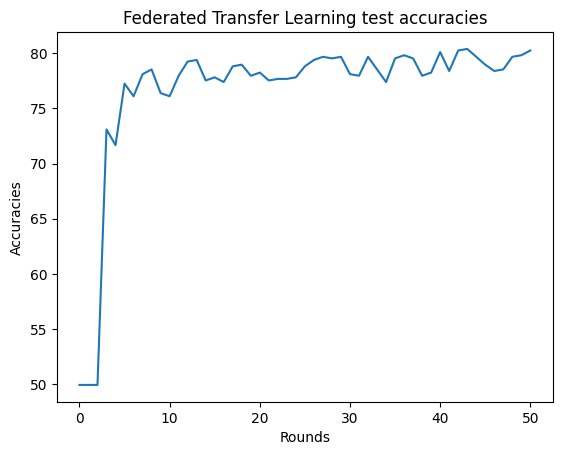

wandb: Network error (ConnectTimeout), entering retry loop.
*** SIGTERM received at time=1723468919 on cpu 4 ***
PC: @     0x7f96a9caae2e  (unknown)  epoll_wait
    @     0x7f96a9bc7520  (unknown)  (unknown)
[2024-08-12 14:21:59,355 E 2289594 2289594] logging.cc:361: *** SIGTERM received at time=1723468919 on cpu 4 ***
[2024-08-12 14:21:59,355 E 2289594 2289594] logging.cc:361: PC: @     0x7f96a9caae2e  (unknown)  epoll_wait
[2024-08-12 14:21:59,355 E 2289594 2289594] logging.cc:361:     @     0x7f96a9bc7520  (unknown)  (unknown)


In [16]:
fl_acc
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Transfer Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')